<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/09_PyTorch_Model_Deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 09. PyTorch Model Deployment.


## 1. Getting Data

The dataset we are going to use is the known: Pizza, steak, sushi 20% dataset from Food101.

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1078 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 39.75 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


Set up device agnostic code first:

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [4]:
# Setup training and test paths
train_dir = data_20_percent_path  / 'train'
test_dir = data_20_percent_path  / 'test'

train_dir, test_dir


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment outline

### 3 Questions
1. What is my most ideal ML model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

** FoodVision Mini ideal use case:** A model that performs well and fast.

* Performs well: 95%+ accuracy
* Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
 * Latency = time for prediction to take place

To try and achieve these goals, we are going to build two model experiments:

1. EffNetB2 feature extractor
2. ViT feature extractor

## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has it base layers frozen and output (or head) leayers customized to fit a certain problem.

In [5]:
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

In [6]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # aka the latest best weights

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup a pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad = False

# 5. Customizing the classifier
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=3),
    nn.Linear(in_features=1408, out_features=3,bias=True)
)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 149MB/s]


In [7]:
### 3.1 Creating a function to make an EffNetB2 feature extractor

In [8]:
def create_effnetb2_model(num_classes:int=3, # default
                          seed:int=42):
  # 1,2,3 steps above: Create weights, transforms,
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze the layers
  for param in model.parameters():
    param.requires_grad = False

  # 5. Change the classifier head
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3,inplace=True),
      nn.Linear(in_features=1408,
                out_features = num_classes)
  )

  return model, transforms

In [9]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

In [10]:
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.2 Creating DataLoaders for EffNetB2


In [12]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names =  data_setup.create_dataloaders(train_dir = train_dir,
                                                                                                  test_dir = test_dir,
                                                                                                  transform = effnetb2_transforms,
                                                                                                  batch_size = 32)
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [16]:
from going_modular.going_modular import engine
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params = effnetb2.parameters(),
                            lr = 1e-3)

# Training function
set_seeds()
effnetb2_results = engine.train(model = effnetb2,
                                train_dataloader = train_dataloader_effnetb2,
                                test_dataloader = test_dataloader_effnetb2,
                                epochs = 10,
                                loss_fn = loss_fn,
                                optimizer = optimizer,
                                device = device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2800 | train_acc: 0.9292 | test_loss: 0.2777 | test_acc: 0.9812
Epoch: 2 | train_loss: 0.2583 | train_acc: 0.9333 | test_loss: 0.2699 | test_acc: 0.9568
Epoch: 3 | train_loss: 0.2467 | train_acc: 0.9479 | test_loss: 0.2457 | test_acc: 0.9750
Epoch: 4 | train_loss: 0.2055 | train_acc: 0.9521 | test_loss: 0.2470 | test_acc: 0.9625
Epoch: 5 | train_loss: 0.2092 | train_acc: 0.9542 | test_loss: 0.2413 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.2686 | train_acc: 0.9333 | test_loss: 0.2274 | test_acc: 0.9750
Epoch: 7 | train_loss: 0.2536 | train_acc: 0.9146 | test_loss: 0.2179 | test_acc: 0.9688
Epoch: 8 | train_loss: 0.2417 | train_acc: 0.9313 | test_loss: 0.2523 | test_acc: 0.9165
Epoch: 9 | train_loss: 0.2466 | train_acc: 0.9271 | test_loss: 0.2340 | test_acc: 0.9227
Epoch: 10 | train_loss: 0.2744 | train_acc: 0.8833 | test_loss: 0.2038 | test_acc: 0.9688
Epoch: 11 | train_loss: 0.2184 | train_acc: 0.9167 | test_loss: 0.2084 | test_acc: 0.9625
Epoch: 12 | train_l

### 3.4 Inspecting EffNetB2 loss curves

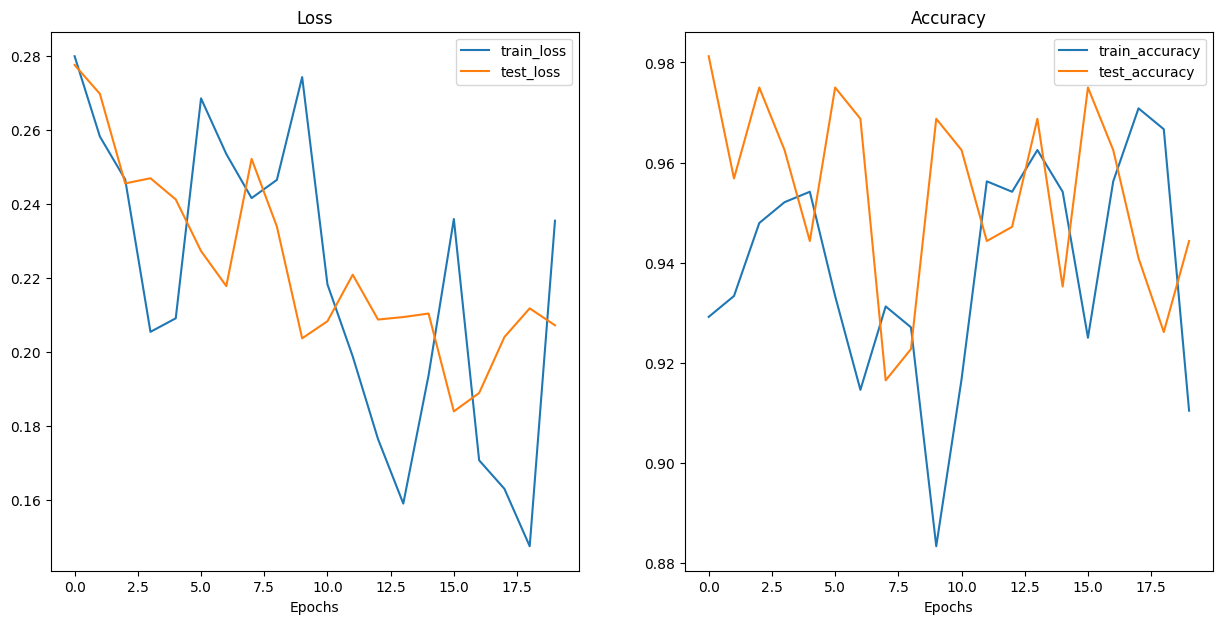

In [17]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [18]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=effnetb2,
                 target_dir = 'models',
                 model_name = "09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor

It is important to know the size of the model, since we want to deploy it.

In [24]:
from pathlib import Path

pretrained_effnetb2_model_size = Path('models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth').stat().st_size // (1024 * 1024)
print(f"pretrained effnetb2 model size: {pretrained_effnetb2_model_size} MB")

pretrained effnetb2 model size: 29 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [26]:
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [28]:
# Create a dict with EffNetB2 stats
effnetb2_stats = {"test_loss":effnetb2_results['test_loss'][-1],
                  "test_acc":effnetb2_results['test_acc'][-1],
                  'total_params':effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.20727651566267014,
 'test_acc': 0.9443181818181818,
 'total_params': 7705221,
 'model_size (MB)': 29}

## 4. Create a ViT feature extractor

We will create a 2nd modelling experiment, this time with ViT feature extreactor.